In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import numpy as np
import iris_cancer
from sklearn.model_selection import train_test_split
import itertools
import lime
import lime.lime_tabular

# Iris-Cancer

To provide an example of input gradients on a slightly more real-world dataset (also not an image or text dataset), let's look at the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/Iris), and then let's combine it with the [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) to show how input gradient explanations can help resolve ambiguities.

## Visualizing Iris Explanations

First let's just train a model to classify iris, and see if we can visualize what input gradients mean for that model (since iris is fairly low-dimensional).

In [2]:
iris = load_iris()

In [3]:
iris_X, iris_Xt, iris_y, iris_yt = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

In [4]:
mlp = MultilayerPerceptron()
mlp.fit(iris_X, iris_y, num_epochs=200)
mlp.score(iris_Xt, iris_yt)

0.98333333333333328

In [5]:
grads0 = mlp.input_gradients(iris_X, 0)
grads1 = mlp.input_gradients(iris_X, 1)
grads2 = mlp.input_gradients(iris_X, 2)
gradsp = mlp.input_gradients(iris_X)

In [6]:
X0 = iris.data[np.argwhere(iris.target==0)][:,0]
X1 = iris.data[np.argwhere(iris.target==1)][:,0]
X2 = iris.data[np.argwhere(iris.target==2)][:,0]

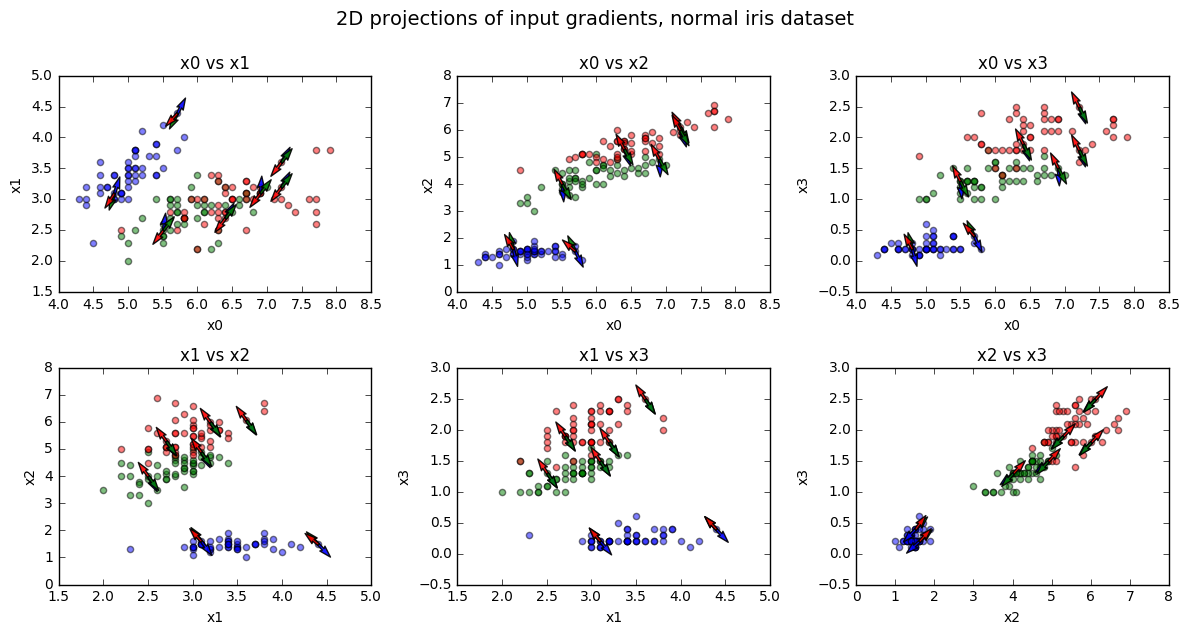

In [409]:
def plot_iris_arrows(i,j, pts=[1,13,10,5,14,20,7]):
  plt.title('x{} vs x{}'.format(i,j))
  plt.xlabel('x{}'.format(i))
  plt.ylabel('x{}'.format(j))
  plt.scatter(X0[:,i], X0[:,j], c='blue', alpha=0.5)
  plt.scatter(X1[:,i], X1[:,j], c='green', alpha=0.5)
  plt.scatter(X2[:,i], X2[:,j], c='red', alpha=0.5)

  def quiv(k):
    kwargs = {'lw':1,'alpha':0.9,'units':'dots'}
    plt.quiver(iris_X[k,i], iris_X[k,j], grads0[k,i], grads0[k,j], color='blue', **kwargs)
    plt.quiver(iris_X[k,i], iris_X[k,j], grads1[k,i], grads1[k,j], color='green', **kwargs)
    plt.quiver(iris_X[k,i], iris_X[k,j], grads2[k,i], grads2[k,j], color='red', **kwargs)
    #plt.quiver(iris_X[k,i], iris_X[k,j], gradsp[k,i], gradsp[k,j], color='black', **kwargs)
    
  for pt in pts:
    quiv(pt)


with figure_grid(2,3) as g:
  g.title('2D projections of input gradients, normal iris dataset')
  for ax, (i, j) in zip(g.each_subplot(), itertools.combinations([0,1,2,3], 2)):
    plot_iris_arrows(i,j)

Input gradients for the probabilities of each class (color-coded) are plotted separately (note the arrow sizes don't provide a sense of the relative magnitudes of each gradient, just the dimension). For the most part, these gradients indicate that the way to increase the probability of a given class is to move in the direction of that class's cluster, though in the $x_0$ vs $x_1$ case, where the red and green-coded classes are intermingled, there isn't a meaningful cluster and the gradients point in random directions.

So basically, input gradients make sense here, and even if we only explained a single example with no knowledge of the dataset, we would be able to gain a lot of information about where the clusters lie.

## (Decoy) Iris-Cancer

Now let's try mashing together the iris and cancer datasets. They have different numbers of features (4 for iris, 30 for cancer), different numbers of classes (3 for iris and 2 for cancer), and finally different numbers of examples (50 per class for iris, many more for cancer). To make everything line up, we'll concatenate the features but only take 100 total examples (50+50 for the two least separable iris classes, and the first 100 breast cancer examples). This splitting occurs in `rrr/iris_cancer.py`.

To make things difficult for our classifier, in our training set, we'll include the somewhat-separable iris features, but in our test set, we'll zero them out.

In [194]:
normal_Xtr_accuracies = []
normal_Xt_accuracies = []
normal_iris_usages = []
normal_iris_tops = []

noiris_Xtr_accuracies = []
noiris_Xt_accuracies = []
noiris_iris_usages = []
noiris_iris_tops = []

for i in range(50):
  X, Xtr, Xt, y, yt = iris_cancer.generate_dataset() # fully regenerates the dataset, random split
  A = np.zeros_like(X).astype(bool)
  A[:, :4] = True

  mlp_normal = MultilayerPerceptron()
  mlp_normal.fit(X, y, num_epochs=200)
  
  mlp_noiris = MultilayerPerceptron(l2_grads=1000)
  mlp_noiris.fit(X, y, A, num_epochs=200)
  
  normal_Xtr_accuracies.append(mlp_normal.score(Xtr, yt))
  normal_Xt_accuracies.append(mlp_normal.score(Xt, yt))
  normal_iris_usages.append(iris_cancer.iris_usage(mlp_normal, Xtr))
  normal_iris_tops.append(np.mean([(np.argsort(np.abs(g))[-10:] < 4).sum() for g in mlp_normal.input_gradients(X)]))
  
  noiris_Xtr_accuracies.append(mlp_noiris.score(Xtr, yt))
  noiris_Xt_accuracies.append(mlp_noiris.score(Xt, yt))
  noiris_iris_usages.append(iris_cancer.iris_usage(mlp_noiris, Xtr))
  noiris_iris_tops.append(np.mean([(np.argsort(np.abs(g))[-10:] < 4).sum() for g in mlp_noiris.input_gradients(X)]))

In [196]:
print(np.mean(normal_Xtr_accuracies))
print(np.mean(normal_Xt_accuracies))
print(np.mean(normal_iris_tops))
print(np.mean(noiris_iris_tops))

0.913333333333
0.815757575758
2.54835820896
0.00358208955224


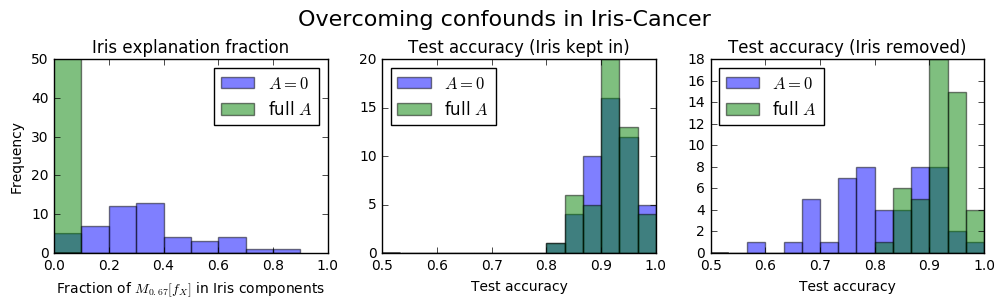

In [201]:
bins = np.arange(0.5,1,0.033333)

plt.figure(figsize=(12,2.5))
plt.suptitle('Overcoming confounds in Iris-Cancer', y=1.1, fontsize=16)

plt.subplot(131)
plt.title('Iris explanation fraction')
plt.hist(normal_iris_usages, label=r'$A=0$', alpha=0.5, bins=np.arange(0,1,0.1))
plt.hist(noiris_iris_usages, label=r'full $A$', alpha=0.5, bins=np.arange(0,1,0.1))
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.xlabel('Fraction of $M_{0.67}[f_X]$ in Iris components')

plt.subplot(132)
plt.title('Test accuracy (Iris kept in)')
plt.xlim(0.5,1)
plt.hist(normal_Xtr_accuracies, label=r'$A=0$', alpha=0.5, bins=bins)
plt.hist(noiris_Xtr_accuracies, label=r'full $A$', alpha=0.5, bins=bins)
plt.legend(loc='best')
plt.xlabel('Test accuracy')
             
plt.subplot(133)
plt.title('Test accuracy (Iris removed)')
plt.xlim(0.5,1)
plt.hist(normal_Xt_accuracies, label=r'$A=0$', alpha=0.5, bins=bins)
plt.hist(noiris_Xt_accuracies, label=r'full $A$', alpha=0.5, bins=bins)
plt.legend(loc='best')
plt.xlabel('Test accuracy')
             
plt.show()

It's a bit random, which isn't necessarily that surprising with 67 training examples and 33 test examples. Still, test accuracy (when we remove iris features) is reliably higher when we penalize the model for having high gradient values in iris features.

## Comparison with LIME

First let's train a model:

In [12]:
X, Xtr, Xt, y, yt = iris_cancer.generate_dataset()
mlp_iris = MultilayerPerceptron()
mlp_iris.fit(X, y, num_epochs=200)
iris_cancer.iris_usage(mlp_iris, X)

0.38585858585858585

Gradients show our model is definitely using Iris features. Let's try LIME:

In [428]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=list(range(34)), class_names=[0,1])

In [429]:
import time
t1 = time.clock()
lime_expls = [lime_explainer.explain_instance(x, mlp_iris.predict_proba, top_labels=1, num_features=10) for x in X]
t2 = time.clock()
grad_expls = mlp_iris.input_gradients(X)
t3 = time.clock()

In [430]:
print('LIME took {:.3f}s/example'.format((t2-t1)/len(lime_expls)))
print('Grads took {:.6f}s/example'.format((t3-t2)/len(grad_expls)))

LIME took 0.850s/example
Grads took 0.000393s/example


In [433]:
preds = mlp_iris.predict(X)
lime_expls = [LocalLinearExplanation.from_lime(X[i], preds[i], lime_expls[i]) for i in range(len(X))]

def iris_usage(expl):
  coefs = np.abs(expl.coefs) 
  return (coefs[:4] > 0).sum() / (coefs > 0).sum()

print('avg % of iris features identified by LIME:', np.mean([iris_usage(e) for e in lime_expls]))

avg % of iris features identified by LIME: 0.0716417910448


Interestingly, LIME doesn't pick up on the Iris features, perhaps because its tabular perturbation strategy is ineffective for this problem. What if we try a different perturbation strategy?

In [434]:
X, Xtr, Xt, y, yt = iris_cancer.generate_dataset()
mlp_iris = MultilayerPerceptron()
mlp_iris.fit(X, y, num_epochs=200)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X, discretize_continuous=False)

In [435]:
t1 = time.clock()
lime_expls0 = [lime_explainer.explain_instance(x, mlp_iris.predict_proba, labels=[0], num_features=10) for x in X]
t2 = time.clock()
grad_expls0 = mlp_iris.input_gradients(X, y=0)
t3 = time.clock()
print('LIME took {:.3f}s/example'.format((t2-t1)/len(lime_cont_expls)))
print('Grads took {:.6f}s/example'.format((t3-t2)/len(grad_expls)))

lime_expls1 = [lime_explainer.explain_instance(x, mlp_iris.predict_proba, labels=[1], num_features=10) for x in X]
grad_expls1 = mlp_iris.input_gradients(X, y=1)

LIME took 0.026s/example
Grads took 0.000066s/example


In [436]:
def lime_coefs(lime_expl,y):
  coefs = np.zeros_like(X[0])
  for idx, wt in lime_expl.local_exp[y]:
    coefs[idx] = wt
  return coefs

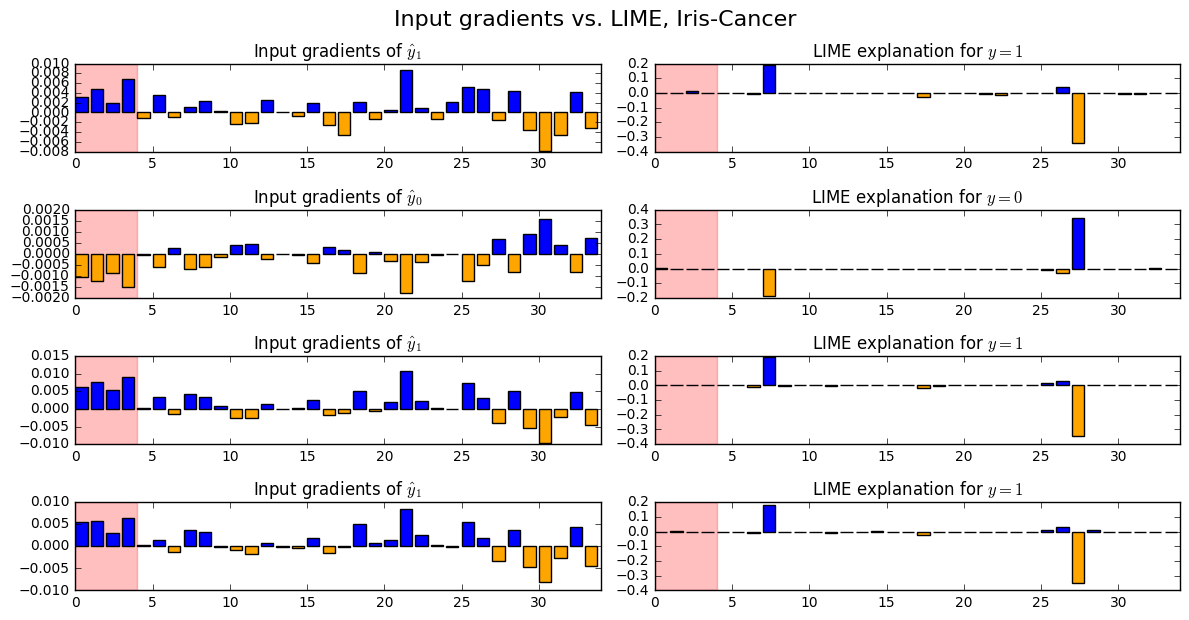

In [437]:
def expl_barchart(coefs):
  colors = ['blue' if coef>0 else 'orange' for coef in coefs]
  plt.axvspan(0, 4, color='red', alpha=0.25, label='Iris')
  plt.bar(range(len(coefs)), coefs, color=colors)
  plt.xlim(0,34)

preds = mlp_iris.predict(X)
with figure_grid(4,2,rowheight=1.5) as g:
  g.fig.suptitle('Input gradients vs. LIME, Iris-Cancer', y=1.025, fontsize=16)
  for i in [1,10,4,6]:
    g.next()
    plt.title('Input gradients of $\hat{{y}}_{{{}}}$'.format(y[i]))
    expl_barchart(grad_expls0[i] if y[i]==0 else grad_expls1[i])
    
    g.next()
    plt.title('LIME explanation for $y={}$'.format(y[i]))
    expl_barchart(lime_coefs(lime_expls0[i] if y[i]==0 else lime_expls1[i], y[i]))

Even with a continuous perturbation strategy, LIME still doesn't identify that Iris features are significant, even though in this case we know from model accuracy results that they are. Furthermore, the input gradients make more intuitive sense given the nature of the dataset; we expect many dimensions to be meaningful (and for the model to meaningfully utilize them) in both Iris and Breast Cancer, which input gradients capture. LIME's approach may be too sparse in this case.

In fairness, we could probably get LIME to work well on this dataset if we implemented more custom perturbation logic (and custom kernels), but the goal is to avoid that as much as possible -- although we did have to use domain knowledge to overcome the Iris confound.

## Find-another-explanation

Let's try our find-another-explanation scheme on this dataset too, then plot results:

In [202]:
def iris_cancer_faes():
  X, Xtr, Xt, y, yt = iris_cancer.generate_dataset()
  A = np.zeros_like(X).astype(bool)
  faes = []

  for i in range(7):
    mlp = MultilayerPerceptron(l2_grads=1000)
    mlp.fit(X, y, A, num_epochs=200)
    faes.append((mlp, mlp.score(Xt,yt), mlp.score(X,y), iris_cancer.iris_usage(mlp, X)))
    A += mlp.largest_gradient_mask(X)

  return faes

fae_groups = [iris_cancer_faes() for _ in range(50)]

In [203]:
testscore_means = [np.mean([fae_group[i][1] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
trainscore_means = [np.mean([fae_group[i][2] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
testscore_errs = [np.std([fae_group[i][1] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
trainscore_errs = [np.std([fae_group[i][2] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
iris_usage_means = [np.mean([fae_group[i][3] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
iris_usage_errs = [np.std([fae_group[i][3] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]

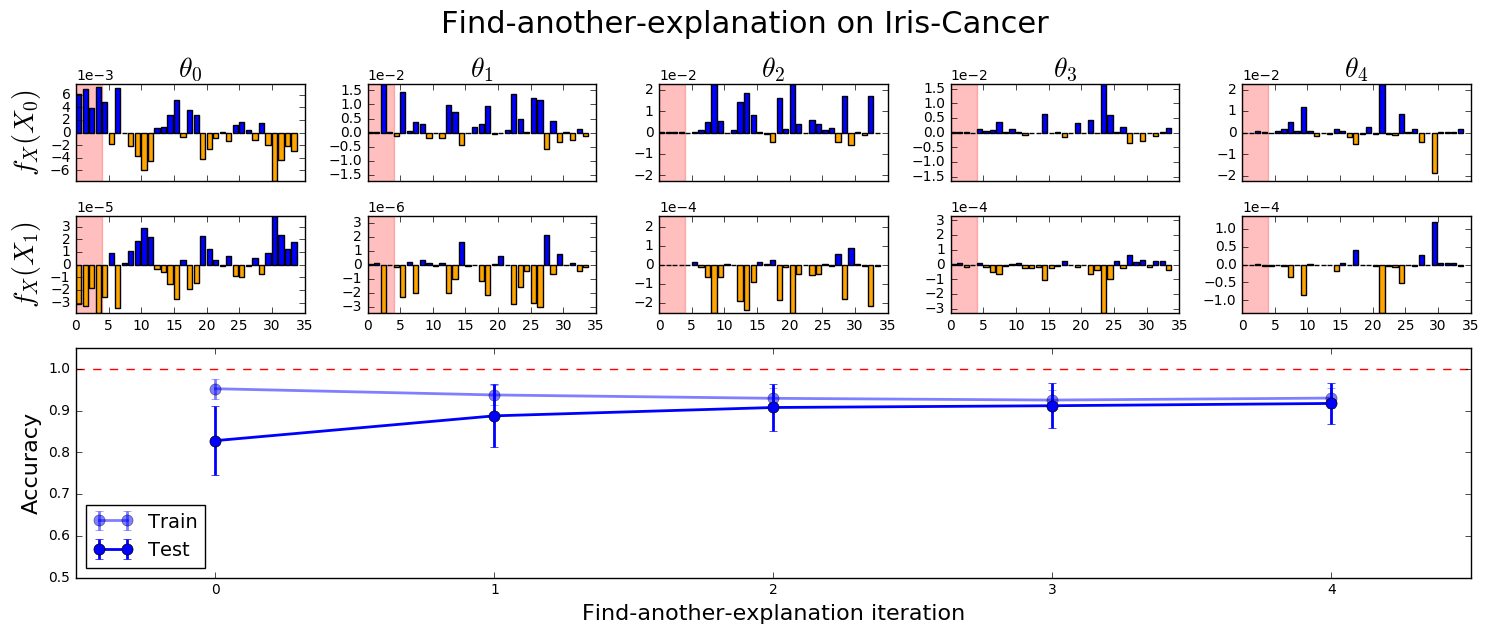

In [424]:
with figure_grid(4,5, rowwidth=15, rowheight=1.5) as g:
  g.fig.suptitle('Find-another-explanation on Iris-Cancer', y=1.05, fontsize=22)
  for jj, j in enumerate([1,5]):
    for i in range(5):
      g.next()
      if jj == 0:
        plt.title(r'$\theta_{{{}}}$'.format(i), fontsize=20)
      if i == 0:
        plt.ylabel(r'$f_X(X_{{{}}})$'.format(jj), fontsize=20)
      plt.axvspan(0, 4, color='red', alpha=0.25)
      grads = fae_groups[5][i][0].input_gradients(X)[j]
      colors = ['blue' if coef>0 else 'orange' for coef in grads]
      plt.bar(range(len(grads)), grads, color=colors)
      plt.ylim(-np.abs(grads).max(), np.abs(grads).max())
      plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
      if jj == 0:
        plt.gca().set_xticklabels([])

  show = 5
  plt.subplot2grid((4,5), (2,0), rowspan=2, colspan=5)
  plt.axhline(1, ls='--', color='red')
  plt.errorbar(list(range(show)), trainscore_means[:show], yerr=trainscore_errs[:show], marker='o', markersize=8, alpha=0.5, lw=2, label='Train')
  plt.errorbar(list(range(show)), testscore_means[:show], yerr=testscore_errs[:show], marker='o', markersize=8, label='Test', lw=2, c='blue')
  plt.legend(loc='best', fontsize=14)
  plt.ylim(0.5,1.05)
  plt.xlim(-0.5, show-0.5)
  plt.xlabel('Find-another-explanation iteration', fontsize=16)
  plt.ylabel('Accuracy', fontsize=16)

In [71]:
iris_usage_means

[0.27813926419479118,
 0.15651711023358289,
 0.083399773314089043,
 0.017479624372572236,
 0.035181563747461106]

So our results are again somewhat random (our dataset is _tiny_), but the overall trend is for test accuracy to increase after the first find-another-explanation iteration (and iris usage to go down, which we can see from the specific explanations we generate and the average fractions of Iris components in the top third).

It's also interesting to see that our explanations get sparser (although not fully, since we're using an L2 penalty instead of an L1 penalty) as we start penalizing more and more elements -- which I guess is only natural, since there are fewer elements the model is effectively allowed to use.